In [77]:
import pandas as pd

df = pd.read_csv('allocs7.csv')
# remove all views
df = df[df['tensor_view_src_id'] == "(nil)"]
df = df.drop_duplicates(subset=['tensor_id'])
df = df.sort_values(by='size', ascending=False, kind='stable')

In [78]:
# find all buffers and their sizes
df['offset+size'] = df['offset'] + df['size']
bufs = df.groupby('buffer_id')
bufs = bufs.agg({'buffer_name': 'first', 'offset+size': 'max'})
bufs.reset_index(inplace=True)
bufs.sort_values(by='buffer_name', inplace=True)
bufs


,buffer_id,buffer_name,offset+size
7,0x56fa9b3b02f0,CPU,430940160
1,0x56fa95d0a890,CUDA0,402653184
5,0x56fa9af97b00,CUDA0,4294705152
6,0x56fa9afff860,CUDA0,155197440
0,0x56fa95cd17d0,CUDA1,134217728
3,0x56fa9ae68ec0,CUDA1,321404928
4,0x56fa9af5b340,CUDA1,1862524928
2,0x56fa9ae63710,CUDA_Host,41967616


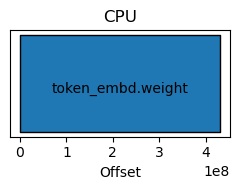

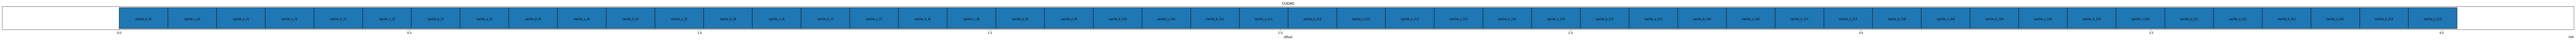

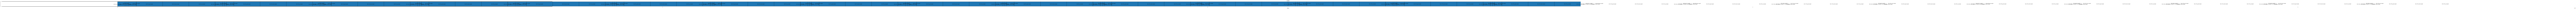

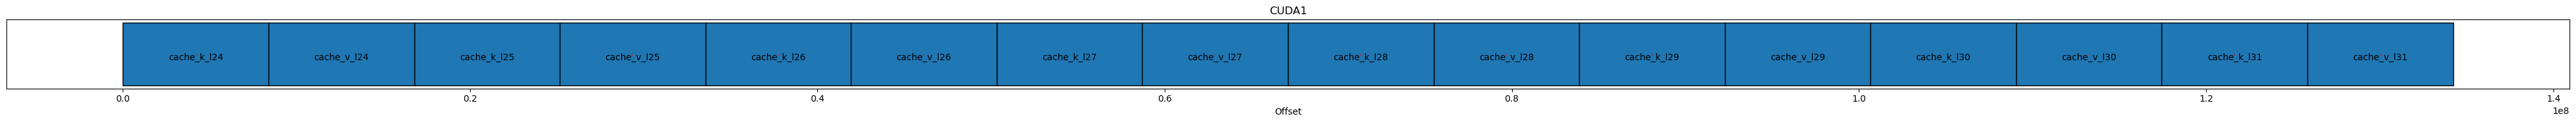

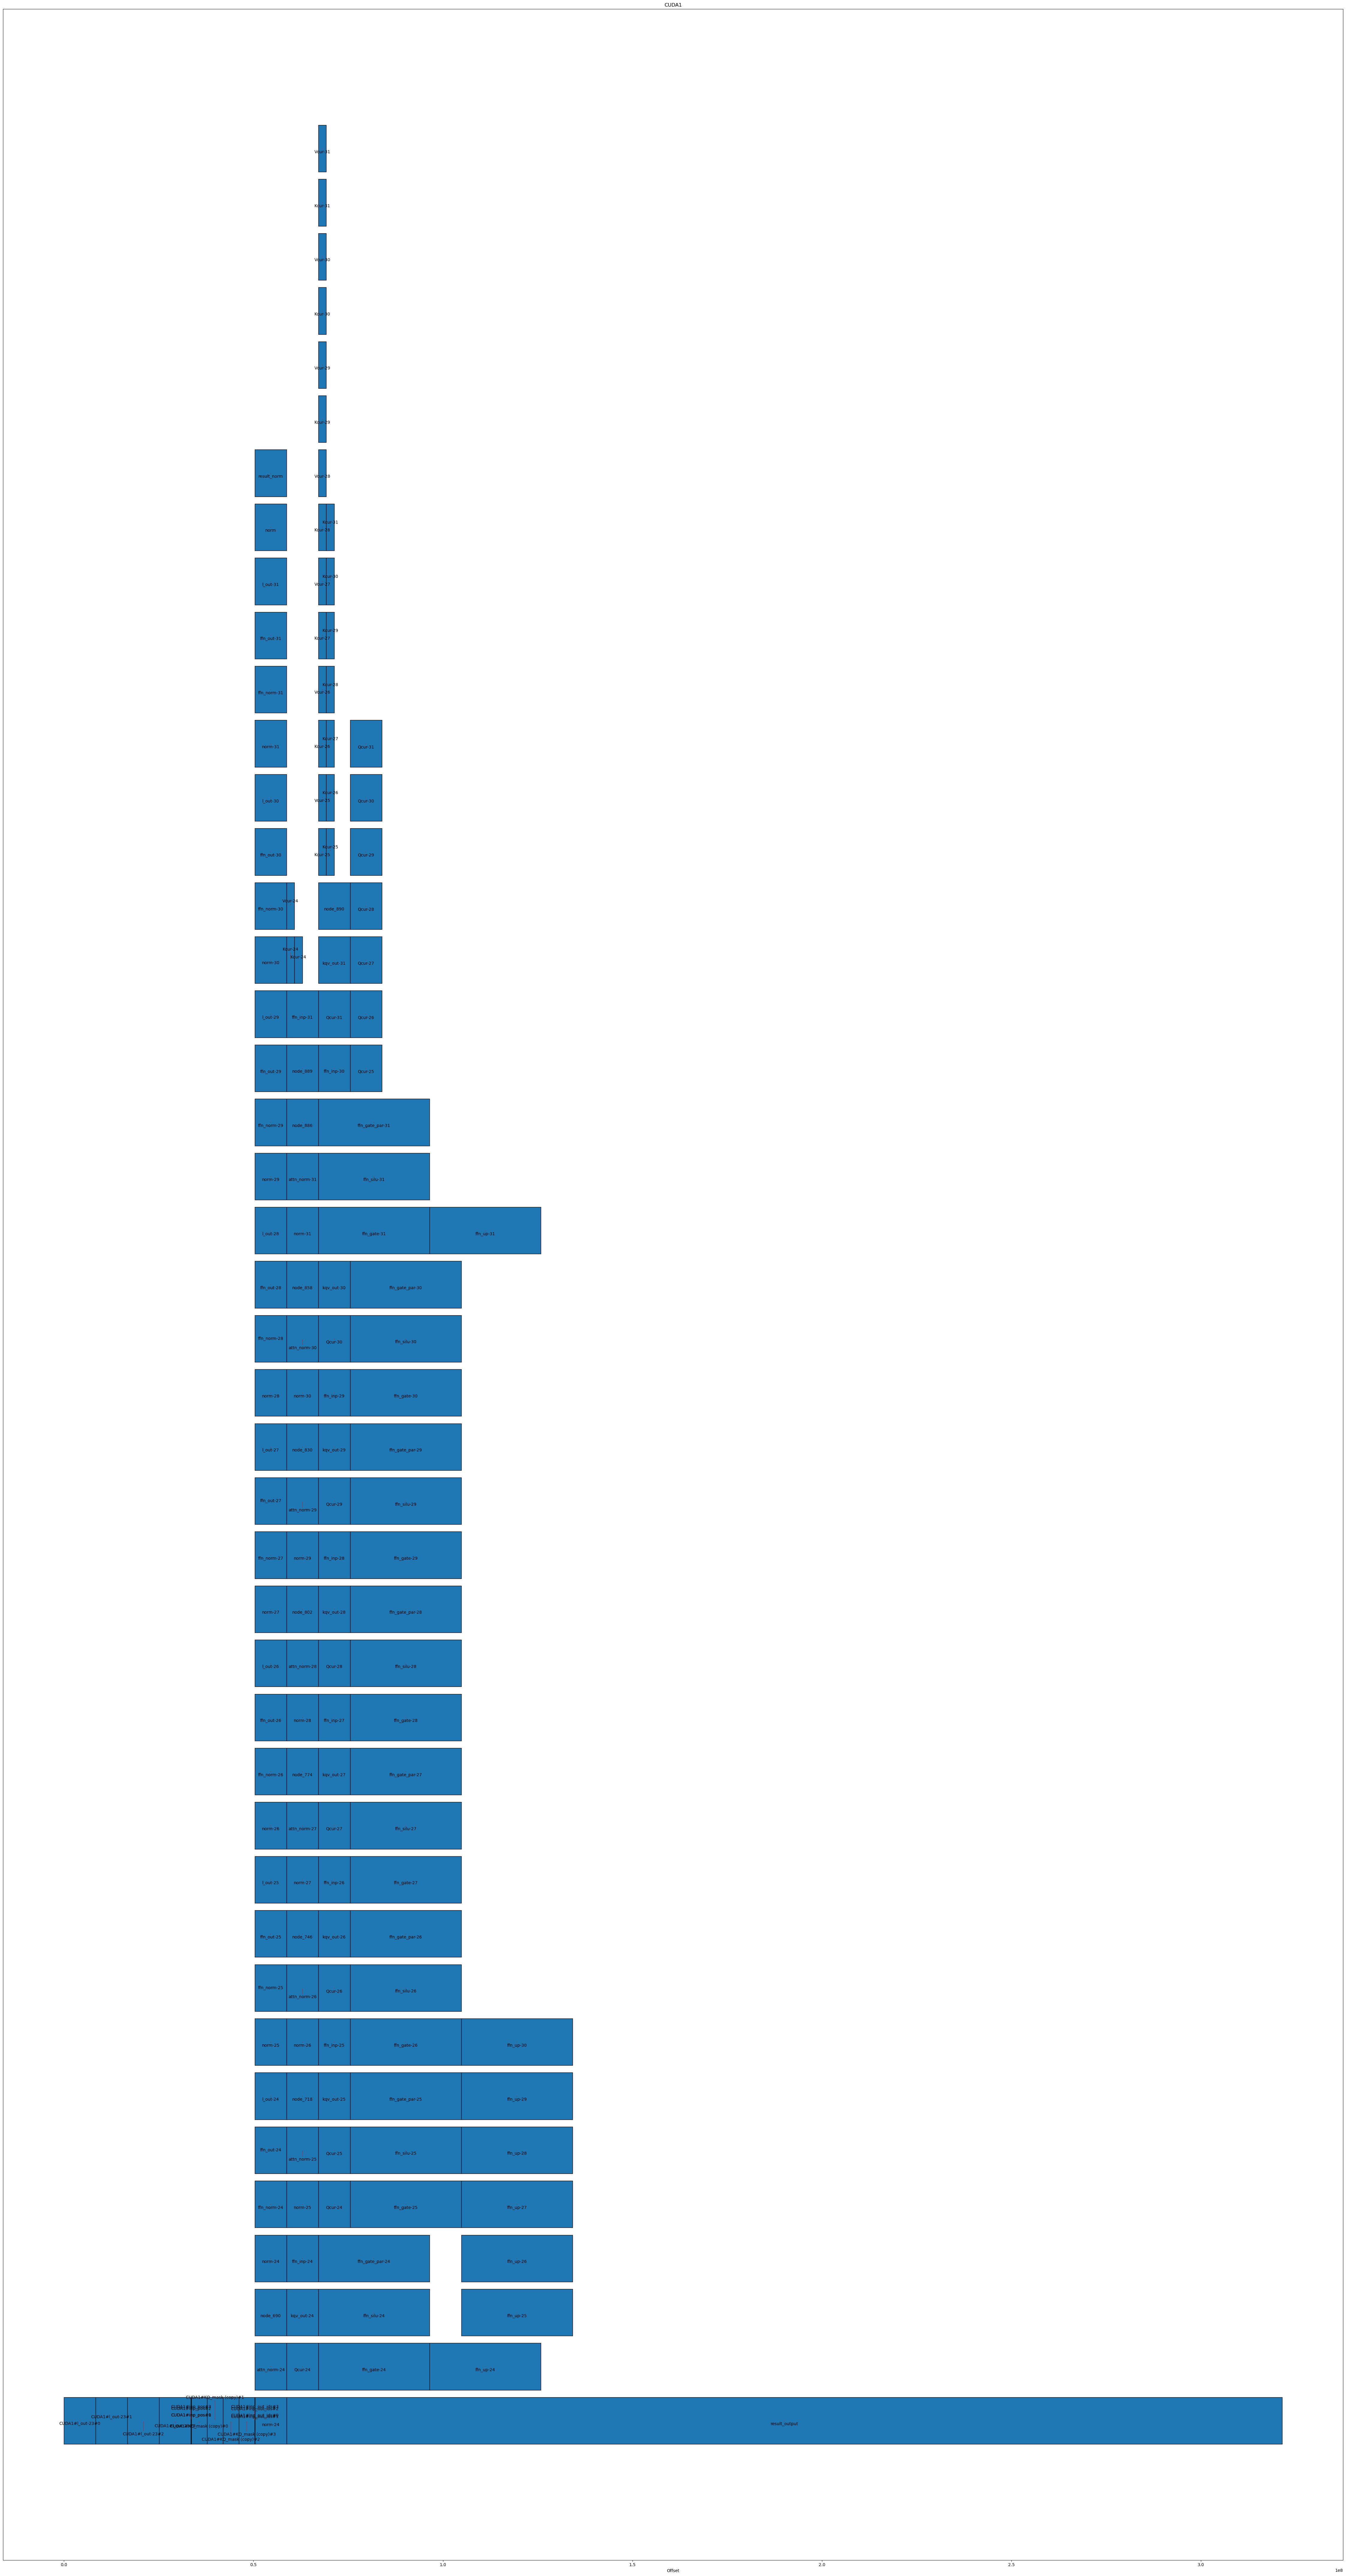

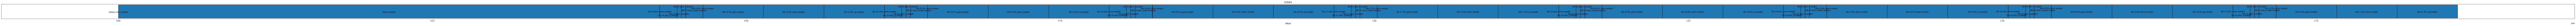

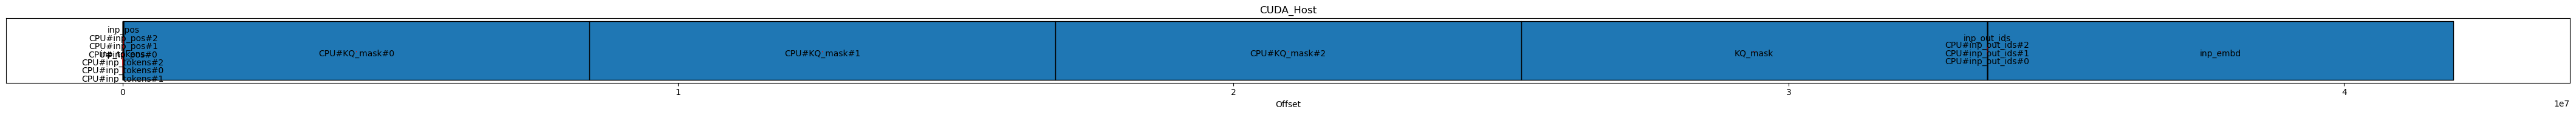

In [79]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

for i, buf in bufs.iterrows():
    buf_id = buf['buffer_id']
    buf_name = buf['buffer_name']
    buf_df = df[df['buffer_id'] == buf_id]

    yranges = dict()
    for _, row in buf_df.iterrows():
        name = row['tensor_name']
        offset = row['offset']
        size = row['size']
        y = 0
        while y in yranges and any((x <= offset and x + w > offset) or (offset <= x and offset + size > x) for x, w in yranges[y]['xranges']):
            y += 1
        if y not in yranges:
            yranges[y] = {'xranges': [], 'labels': []}
        yranges[y]['xranges'].append((offset, size))
        yranges[y]['labels'].append(name)

    fig, ax = plt.subplots()

    width = max(len(data['xranges']) for data in yranges.values())
    height = len(yranges)
    fig.set_size_inches(width * 2.5, height * 2)

    ax.set_title(buf_name)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('Offset')
    
    texts = []
    bars = []
    for y, data in yranges.items():
        xranges = data['xranges']
        labels = data['labels']
        h = 15
        # add some margin between bars
        #x_margin = 102400
        #for i in range(len(xranges) - 1):
        #    if xranges[i][1] > x_margin*2:
        #        xranges[i] = (xranges[i][0] + x_margin, xranges[i][1] - x_margin)
        y_margin = 1
        cur_bars = ax.broken_barh(xranges, (y*h + y_margin, h - y_margin*2), edgecolor='black')
        cur_texts = [ax.annotate(labels[i], xy=(x + width / 2, y*h + h/2 + x/1e10), 
                                        xytext=(x + width / 2, y*h + h/2 + x/1e10), ha='center', va='center') for i, (x, width) in enumerate(xranges)]
        bars.append(cur_bars)
        texts.extend(cur_texts)
        
    texts = adjust_text(texts, only_move="y", arrowprops=dict(arrowstyle="->", color='r', lw=0.5), expand=(1.05, 1.25))

    fig.tight_layout()